# Comparing Slovenia and Croatia's Energy Use Sources with Deep Learning Models

## Introduction

intro intro intro

## Theoretical Background

- talk about different deep learning models
- show some basic plots and examples
- talk about what they're good for

## Methodology

Mostly show and comment on the code you wrote

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist
scaler = StandardScaler()
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

In [54]:
np.random.seed(3799)

In [55]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/energy-data/master/owid-energy-data.csv')

In [56]:
# Check the amount of rows and features
df.shape

(21812, 130)

In [57]:
# Check how many nans there are in the columns
pd.set_option('display.max_rows', None)
df.isna().sum()[df.isna().sum() > 0]

iso_code                                         5000
population                                       3365
gdp                                             10037
biofuel_cons_change_pct                         20006
biofuel_cons_change_twh                         19016
biofuel_cons_per_capita                         19412
biofuel_consumption                             18936
biofuel_elec_per_capita                         16242
biofuel_electricity                             15978
biofuel_share_elec                              16001
biofuel_share_energy                            19034
carbon_intensity_elec                           15977
coal_cons_change_pct                            16516
coal_cons_change_twh                            16398
coal_cons_per_capita                            17060
coal_consumption                                16293
coal_elec_per_capita                            15718
coal_electricity                                15103
coal_prod_change_pct        

There are an overwhelmingly large amount of NaNs in this dataset. I need a way to focus on the data that showcases a complete view of the data, i.e., something that has a lot of data present. I will attempt to solve this by calculating the percentages of NaNs by each country to determine if there are any countries containing a low amount of NaNs. I want this because imputing or utilizing methods to fill in NaNs to select my desired countries could result in an unrepresentative dataset, so it is best to work with the countries that are most complete.

In [59]:
# reset the display to not show all rows
pd.reset_option('display.max_rows')

In [60]:
# calculate the percentage of NaNs present in each row
df_copy = df.copy()
df_copy['nan_percent'] = df_copy.isna().mean(axis=1) * 100

# group by country and derive the mean of the NaN percentage to find the country with the lowest amount of NaNs
mean_nan_percent_by_country = df_copy.groupby('country')['nan_percent'].mean()

# selecting for countries that have their data with less than 10% of NaNs
print(mean_nan_percent_by_country[mean_nan_percent_by_country < 10])

country
Croatia     7.081448
Slovenia    4.954751
Name: nan_percent, dtype: float64


The criteria of less than 10% of NaNs shows that there are only two countries present that are able to be worked with. We will use these specific countries for our purposes. Now, we will clean the rest of the NaNs in these countries since utilizing particular unsupervised learning methods requires no NaNs to be present.

In [62]:
croatia = df[df['country'] == 'Croatia']

In [63]:
# determine the columns containing NaNs
croatia_nans = croatia.isna().sum()[croatia.isna().sum() > 0]
croatia_nans

gdp                                  1
biofuel_cons_change_pct             19
biofuel_cons_change_twh             18
biofuel_cons_per_capita             17
biofuel_consumption                 17
biofuel_share_energy                17
coal_cons_change_pct                 1
coal_cons_change_twh                 1
coal_prod_change_pct                26
coal_prod_change_twh                10
coal_prod_per_capita                 9
coal_production                      9
energy_cons_change_pct               1
energy_cons_change_twh               1
energy_per_gdp                       1
fossil_cons_change_pct               1
fossil_cons_change_twh               1
gas_cons_change_pct                  1
gas_cons_change_twh                  1
gas_prod_change_pct                 10
gas_prod_change_twh                 10
gas_prod_per_capita                  9
gas_production                       9
hydro_cons_change_pct                1
hydro_cons_change_twh                1
low_carbon_cons_change_pc

In [64]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
croatia.shape

(34, 130)

In [65]:
# remove the columns that contain more than one NaN
croatia_no_nans = croatia.loc[:, croatia.isna().sum() <= 1].copy()

In [66]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder = croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]
croatia_nan_idxs = {col: croatia_no_nans.index[croatia_no_nans[col].isna()].tolist() for col in remainder.index}
croatia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Clearly, the 5007th index is empty, so we can be confident to drop that. Also, the 5040th index has a couple of missing value, which we will drop too.

In [68]:
# drop the 5040th and 5007th indices
croatia_no_nans.drop([5040, 5007], inplace=True)

In [69]:
# double check that there are no more NaNs
croatia_no_nans.isna().sum()[croatia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [70]:
# Set up slovenia to be cleaned
slovenia = df[df['country'] == 'Croatia']

In [71]:
# determine the columns containing NaNs
slovenia_nans = slovenia.isna().sum()[slovenia.isna().sum() > 0]
slovenia_nans.head()

gdp                         1
biofuel_cons_change_pct    19
biofuel_cons_change_twh    18
biofuel_cons_per_capita    17
biofuel_consumption        17
dtype: int64

In [72]:
# Check for rows because we require columns with NaNs that aren't a large proportion of the rows
slovenia.shape

(34, 130)

In [73]:
# remove the columns that contain more than one NaN
slovenia_no_nans = slovenia.loc[:, slovenia.isna().sum() <= 1].copy()

In [74]:
# need to find out where the remainder of the NaNs are to determine how they should be removed or imputed
remainder_slov = slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]
slovenia_nan_idxs = {col: slovenia_no_nans.index[slovenia_no_nans[col].isna()].tolist() for col in remainder_slov.index}
slovenia_nan_idxs

{'gdp': [5040],
 'coal_cons_change_pct': [5007],
 'coal_cons_change_twh': [5007],
 'energy_cons_change_pct': [5007],
 'energy_cons_change_twh': [5007],
 'energy_per_gdp': [5040],
 'fossil_cons_change_pct': [5007],
 'fossil_cons_change_twh': [5007],
 'gas_cons_change_pct': [5007],
 'gas_cons_change_twh': [5007],
 'hydro_cons_change_pct': [5007],
 'hydro_cons_change_twh': [5007],
 'low_carbon_cons_change_pct': [5007],
 'low_carbon_cons_change_twh': [5007],
 'nuclear_cons_change_twh': [5007],
 'oil_cons_change_pct': [5007],
 'oil_cons_change_twh': [5007],
 'other_renewables_cons_change_twh': [5007],
 'renewables_cons_change_pct': [5007],
 'renewables_cons_change_twh': [5007],
 'solar_cons_change_twh': [5007],
 'wind_cons_change_twh': [5007]}

Luckily, the Slovenia data is showing the same missed values that Croatia has, which helps us for comparison their countries for our models.

In [76]:
# drop the 5040th and 5007th indices
slovenia_no_nans.drop([5040, 5007], inplace=True)

In [77]:
# double check that there are no more NaNs
slovenia_no_nans.isna().sum()[slovenia_no_nans.isna().sum() > 0]

Series([], dtype: int64)

In [78]:
# assign the variables back to workable names for efficiency
slovenia_df = slovenia_no_nans
croatia_df = croatia_no_nans

In [79]:
# check for correlations between remaining columns
df_corr_croatia = croatia_df.drop(['year', 'country', 'iso_code'], axis = 1).copy()
df_corr_slovenia = slovenia_df.drop(['year', 'country', 'iso_code'], axis = 1).copy()

In [80]:
consumption_columns_croatia = [col for col in df_corr_croatia.columns if 'consumption' in col]
consumption_columns_slovenia = [col for col in df_corr_slovenia.columns if 'consumption' in col]

In [81]:
croatia_consumption = df_corr_croatia[consumption_columns_croatia]
slovenia_consumption = df_corr_slovenia[consumption_columns_slovenia]

In [82]:
years_croatia = croatia_df['year']
years_slovenia = slovenia_df['year']

In [83]:
croatia_scaled = StandardScaler().fit_transform(croatia_consumption)
slovenia_scaled = StandardScaler().fit_transform(slovenia_consumption)

In [84]:
croatia_dfscaled = pd.DataFrame(croatia_scaled, columns=croatia_consumption.columns, index=years_croatia.values)
slovenia_dfscaled = pd.DataFrame(slovenia_scaled, columns=slovenia_consumption.columns, index=years_slovenia.values)

In [85]:
# print out the high correlations to see what columns are most descriptive 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
corr = df_corr_croatia.corr()
threshold = 0.99

high_corr = (corr.unstack().reset_index().rename(columns={0: 'Correlation', 'level_0': 'Column1', 'level_1': 'Column2'}))
high_corr = high_corr[high_corr['Column1'] != high_corr['Column2']]
high_corr = high_corr[high_corr['Correlation'].abs() > threshold]

print(high_corr)
pd.reset_option('display.max_rows')

                                            Column1  \
215                         biofuel_elec_per_capita   
216                         biofuel_elec_per_capita   
284                         biofuel_elec_per_capita   
285                         biofuel_elec_per_capita   
288                         biofuel_elec_per_capita   
290                         biofuel_elec_per_capita   
291                         biofuel_elec_per_capita   
293                         biofuel_elec_per_capita   
320                             biofuel_electricity   
322                             biofuel_electricity   
390                             biofuel_electricity   
391                             biofuel_electricity   
394                             biofuel_electricity   
396                             biofuel_electricity   
397                             biofuel_electricity   
399                             biofuel_electricity   
426                              biofuel_share_elec   
427       

In [86]:
croatia_dfscaled

,coal_consumption,fossil_fuel_consumption,gas_consumption,hydro_consumption,low_carbon_consumption,nuclear_consumption,oil_consumption,other_renewable_consumption,primary_energy_consumption,renewables_consumption,solar_consumption,wind_consumption
1991,-0.153238,-1.175144,-1.445166,-0.456225,-0.828351,0.0,-0.944475,-0.556000,-1.622952,-0.828351,-0.575527,-0.662453
1992,-0.461822,-1.147823,-1.048143,-1.461134,-1.633873,0.0,-0.944475,-0.567048,-2.022605,-1.633873,-0.575527,-0.662453
1993,-0.797890,-0.802002,-0.419524,-1.289508,-1.487351,0.0,-0.613496,-0.531353,-1.596528,-1.487351,-0.575527,-0.662453
1994,-1.510528,-1.010733,-1.122125,-0.533370,-0.892959,0.0,-0.417765,-0.567048,-1.491691,-0.892959,-0.575527,-0.662453
1995,-1.722680,-0.738254,-1.969474,-0.321582,-0.721517,0.0,0.270179,-0.558549,-1.126290,-0.721517,-0.575527,-0.662453
1996,-1.900116,-0.744932,-0.723265,1.540880,0.765849,0.0,-0.094232,-0.558549,-0.344475,0.765849,-0.575527,-0.662453
1997,-1.338396,-0.127482,-0.299131,-0.175960,-0.610992,0.0,0.361206,-0.580646,-0.452371,-0.610992,-0.575527,-0.662453
1998,-1.398184,0.461433,-0.764162,-0.032361,-0.490544,0.0,1.271019,-0.558549,0.204789,-0.490544,-0.575527,-0.662453
1999,-1.545726,0.403392,-0.603791,1.083210,0.400353,0.0,1.191694,-0.558549,0.618633,0.400353,-0.575527,-0.662453
2000,-0.281493,0.044700,-0.499021,0.336318,-0.202116,0.0,0.309690,-0.580646,-0.062014,-0.202116,-0.575527,-0.662453


## PCA/SVD Analysis

Discussion: Plot the data in the first two principal components. What, if any, structure exists inherently within the data? How does this differ from plotting on two original features?

Plot/Discussion: After clustering, which observations belong to the same cluster? Look at the underlying data and see what might be similar between them, and how these differ from observations in other clusters. How can the groups be interpreted?


## K-Means Clustering

Discuss: In the context of your data, how can the U and V* matrix from the SVD (or "x" and "rotation" from PCA) be interpreted?

## Heirarchical Clustering

### How do traditional and renewable energy sources cluster based on their usage characteristics in Slovenia and Croatia?

In [93]:
np.random.seed(3799)

In [95]:
croa_tf = croatia_dfscaled.transpose()
slov_tf = slovenia_dfscaled.transpose()

In [97]:
# Getting the energy types as the labels
croa_label = croa_tf.index
slov_label = slov_tf.index

In [99]:
HClust = AgglomerativeClustering

### Croatia

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115]),
 [Text(5, 0, 'primary_energy_consumption'),
  Text(15, 0, 'fossil_fuel_consumption'),
  Text(25, 0, 'oil_consumption'),
  Text(35, 0, 'nuclear_consumption'),
  Text(45, 0, 'coal_consumption'),
  Text(55, 0, 'gas_consumption'),
  Text(65, 0, 'other_renewable_consumption'),
  Text(75, 0, 'solar_consumption'),
  Text(85, 0, 'wind_consumption'),
  Text(95, 0, 'hydro_consumption'),
  Text(105, 0, 'low_carbon_consumption'),
  Text(115, 0, 'renewables_consumption')])

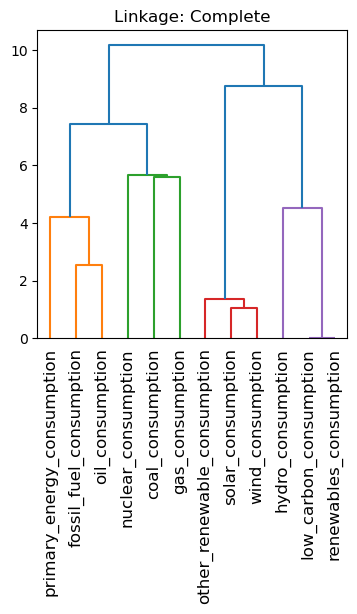

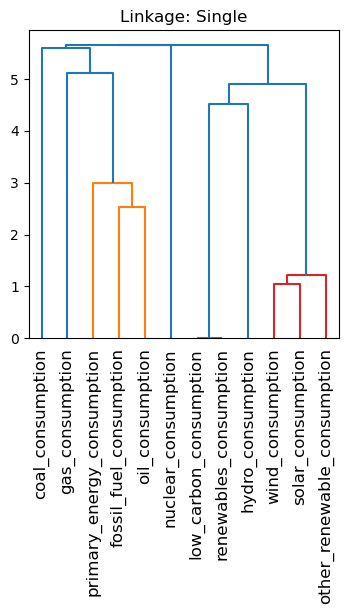

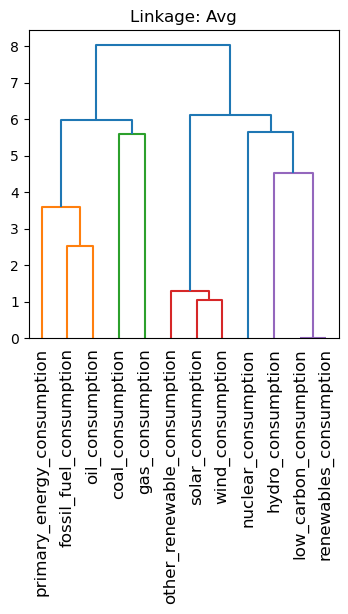

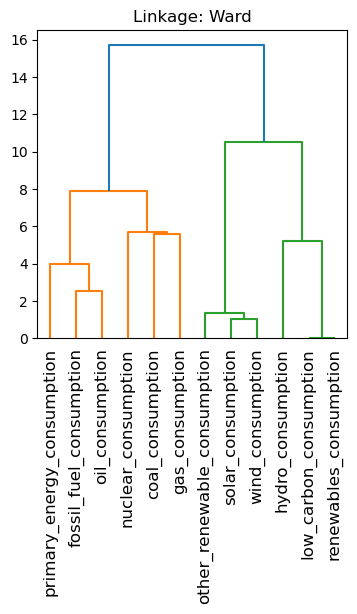

In [102]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp = compute_linkage(complete)
ax.set_title("Linkage: Complete");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
single = HClust(distance_threshold = 0, n_clusters = None, linkage = 'single').fit(croa_tf)
link_comp = compute_linkage(single)
ax.set_title("Linkage: Single");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
average = HClust(distance_threshold = 0, n_clusters = None, linkage = 'average').fit(croa_tf)
link_comp = compute_linkage(average)
ax.set_title("Linkage: Avg");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ward = HClust(distance_threshold = 0, n_clusters = None, linkage = 'ward').fit(croa_tf)
link_comp = compute_linkage(ward)
ax.set_title("Linkage: Ward");
_ = dendrogram(link_comp, ax = ax, labels = np.array(croa_label))
plt.xticks(rotation=90)

### Slovenia

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115]),
 [Text(5, 0, 'primary_energy_consumption'),
  Text(15, 0, 'fossil_fuel_consumption'),
  Text(25, 0, 'oil_consumption'),
  Text(35, 0, 'nuclear_consumption'),
  Text(45, 0, 'coal_consumption'),
  Text(55, 0, 'gas_consumption'),
  Text(65, 0, 'other_renewable_consumption'),
  Text(75, 0, 'solar_consumption'),
  Text(85, 0, 'wind_consumption'),
  Text(95, 0, 'hydro_consumption'),
  Text(105, 0, 'low_carbon_consumption'),
  Text(115, 0, 'renewables_consumption')])

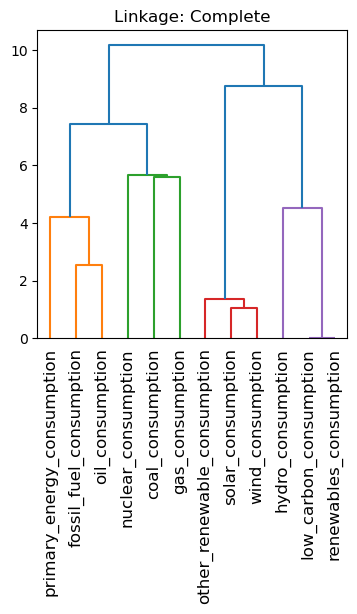

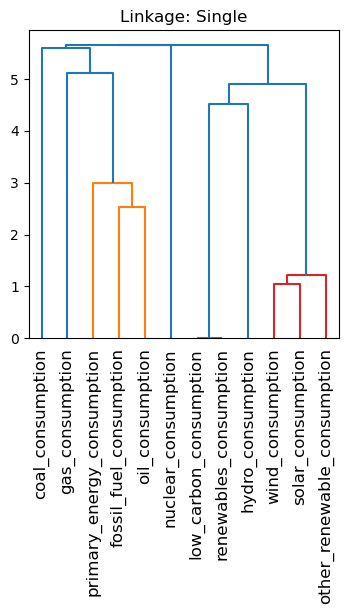

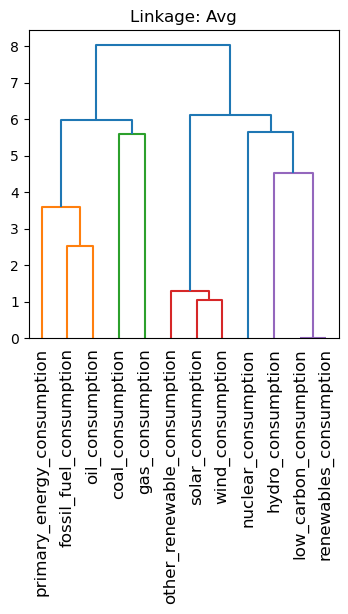

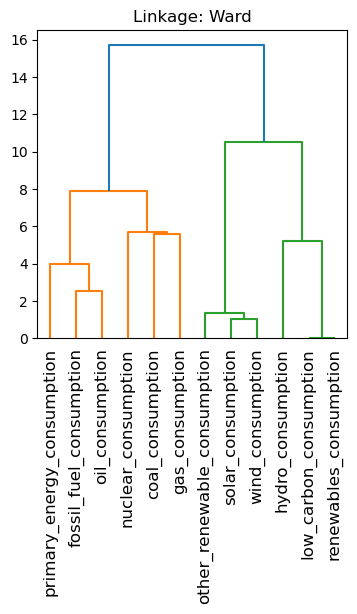

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp = compute_linkage(complete)
ax.set_title("Linkage: Complete");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
single = HClust(distance_threshold = 0, n_clusters = None, linkage = 'single').fit(slov_tf)
link_comp = compute_linkage(single)
ax.set_title("Linkage: Single");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
average = HClust(distance_threshold = 0, n_clusters = None, linkage = 'average').fit(slov_tf)
link_comp = compute_linkage(average)
ax.set_title("Linkage: Avg");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ward = HClust(distance_threshold = 0, n_clusters = None, linkage = 'ward').fit(slov_tf)
link_comp = compute_linkage(ward)
ax.set_title("Linkage: Ward");
_ = dendrogram(link_comp, ax = ax, labels = np.array(slov_label))
plt.xticks(rotation=90)

All four model types had similar groupings so I chose complete linkage as I felt it showed the data in the cleanest way

## Complete Linkage: Croatia vs Slovenia

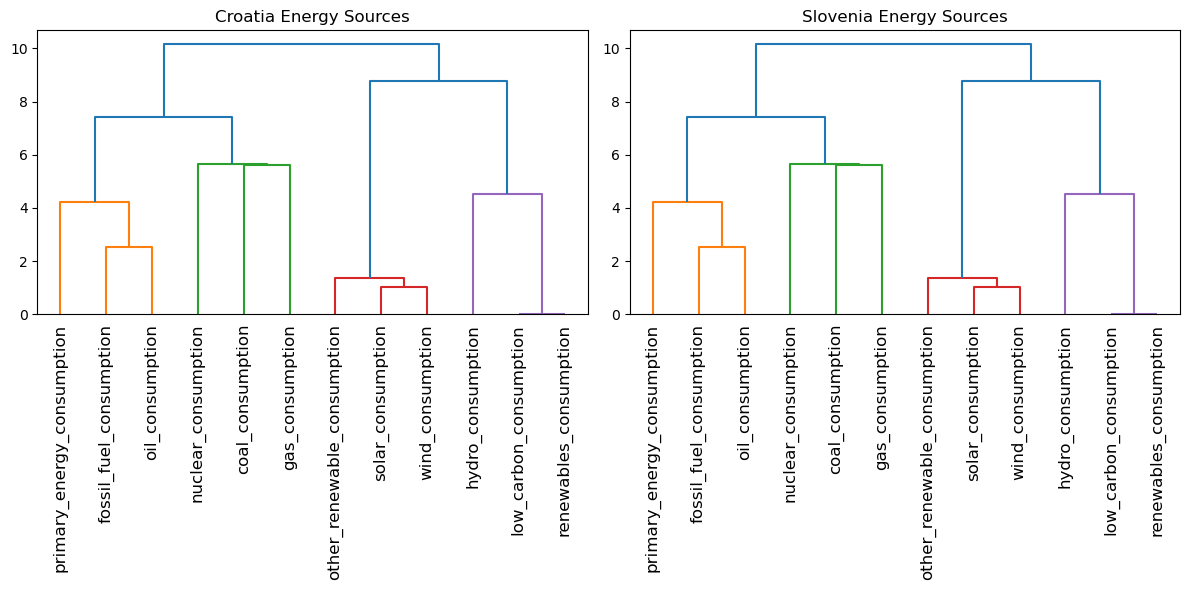

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp = compute_linkage(complete)
ax1.set_title("Croatia Energy Sources");
_ = dendrogram(
    link_comp, 
    ax = ax1, 
    labels = np.array(croa_label),)
ax1.tick_params(axis = 'x', rotation = 90)

complete = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp = compute_linkage(complete)
ax2.set_title("Slovenia Energy Sources");
_ = dendrogram(link_comp, ax = ax2, labels = np.array(slov_label))
ax2.tick_params(axis = 'x', rotation = 90)

plt.tight_layout()
plt.show()

Croatia Observations: 
- Fossil Fuels (Orange) : primary energy, fossil fuel, oil, coal, and gas consumption are closely related and suggest that they're used similarly
- Nuclear & Solar (Green): Nuclear consumption and solar consumption appear in the same group, but with considerable distance
Renewables & Hydro (Red/Blue): Hydro consumption forms its own distinct group, separate from other renewables, showing it has unique characteristics

Slovenia Observations:
- Traditional Energy Cluster (Orange): Similar to Croatia, primary energy and fossil fuel consumption cluster together
- Nuclear & Coal Cluster (Green): Slovenia shows nuclear and coal consumption closely linked, unlike Croatia
- Low Carbon & Renewables (Red): Low carbon and renewables form a tight cluster
Hydro (Purple): Hydro consumption stands alone as a separate energy source

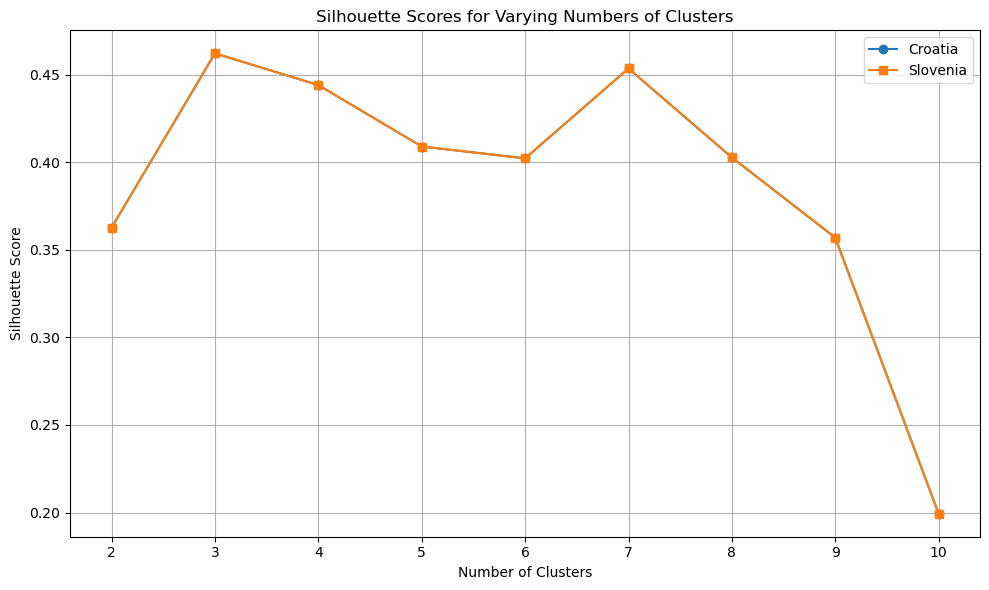

In [110]:
def evaluate_clusters_silhouette(data, link, max = 10):
    silhouette_scores = []
    cluster_range = range(2, max + 1) 
    
    for n_clusters in cluster_range:
        cluster_labels = fcluster(link, n_clusters, criterion = 'maxclust')
        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
    return cluster_range, silhouette_scores

# Croatian data
complete_croa = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(croa_tf)
link_comp_croa = compute_linkage(complete_croa)
croa_range, croa_scores = evaluate_clusters_silhouette(croa_tf, link_comp_croa)

# Slovenian data
complete_slov = HClust(distance_threshold = 0, n_clusters = None, linkage = 'complete').fit(slov_tf)
link_comp_slov = compute_linkage(complete_slov)
slov_range, slov_scores = evaluate_clusters_silhouette(slov_tf, link_comp_slov)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(croa_range, croa_scores, 'o-', label = 'Croatia')
plt.plot(slov_range, slov_scores, 's-', label = 'Slovenia')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Varying Numbers of Clusters')
plt.legend()
plt.grid(True)
plt.xticks(list(croa_range))
plt.tight_layout()
plt.show()

After running the silhouette analysis, there is more confidence in the conclusion that three groups is a strong grouping for these energy use variables

Cross-Country Differences:
- Croatia groups nuclear with fossil fuels, while Slovenia places it with oil, coal, and gas
- Slovenia shows more distinct separation between primary/fossil fuel consumption and other traditional energy sources

However, overall their use is rather similar which could be attributed to their proximity as neighboring countries